In [1]:
import os
from PIL import Image

image_folder = "men_random_50"   # <-- this is the actual correct path
valid_ext = (".jpg", ".jpeg", ".png", ".webp")
image_paths = []
images = []

for fname in os.listdir(image_folder):
    if fname.lower().endswith(valid_ext):
        fpath = os.path.join(image_folder, fname)
        img = Image.open(fpath).convert("RGB")
        images.append(img)
        image_paths.append(fpath)

print(f"Loaded {len(images)} images.")

Loaded 50 images.


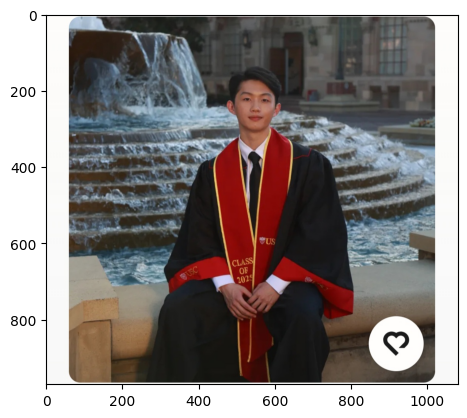

In [2]:
import matplotlib.pyplot as plt

plt.imshow(images[0])
plt.show()

In [3]:
import base64
import requests
import json
import io
import numpy as np

from langchain_huggingface import HuggingFaceEndpoint
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Load HF Token
from dotenv import load_dotenv
load_dotenv()
HF_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")

print("HF Token Loaded:", HF_TOKEN is not None)

HF Token Loaded: True


In [4]:
# !pip install transformers accelerate timm open_clip_torch

In [5]:
import torch
import open_clip
from PIL import Image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms(
    "hf-hub:laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
)
model = model.to(DEVICE)
tokenizer = open_clip.get_tokenizer(
    "hf-hub:laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
)


c:\Users\aryan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.sparse import csr_matrix, issparse


In [6]:
# import torch
# import open_clip
# from PIL import Image

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# MODEL_NAME = "hf-hub:laion/CLIP-ViT-H-14-laion2B-s32B-b79K"

# # Load the model + preprocessors
# model, _, preprocess = open_clip.create_model_and_transforms(MODEL_NAME)
# model = model.to(DEVICE)

# # Load tokenizer
# tokenizer = open_clip.get_tokenizer(MODEL_NAME)

# print("Loaded best-accuracy CLIP model:", MODEL_NAME)
# print("Embedding dim:", model.text_projection.shape[1])

In [7]:
def encode_image(path):
    img = Image.open(path).convert("RGB")
    tensor = preprocess(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        emb = model.encode_image(tensor)
        emb = emb / emb.norm(dim=-1, keepdim=True)

    return emb.squeeze(0).cpu().numpy()

In [8]:
def encode_folder(folder_path):
    vectors = []
    paths = []

    for fname in os.listdir(folder_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png", ".webp")):
            path = os.path.join(folder_path, fname)
            vec = encode_image(path)

            vectors.append(vec)
            paths.append(path)

    return np.vstack(vectors), paths

In [9]:
def load_images_from_folder(folder_path, valid_ext=(".jpg", ".jpeg", ".png", ".webp")):
    image_paths = []
    images = []

    # Sort files for deterministic ordering
    for fname in sorted(os.listdir(folder_path)):
        if not fname.lower().endswith(valid_ext):
            continue

        fpath = os.path.join(folder_path, fname)

        try:
            with Image.open(fpath) as img:
                img = img.convert("RGB")
                images.append(img.copy())   # .copy() prevents Windows file locks
                image_paths.append(fpath)
        except Exception as e:
            print(f"[Warning] Could not load {fpath}: {e}")

    print(f"Loaded {len(images)} valid images from '{folder_path}'.")
    return images, image_paths


# ---- RUN IT ----
image_folder = "men_random_50"
images, image_paths = load_images_from_folder(image_folder)


Loaded 50 valid images from 'men_random_50'.


In [10]:
def encode_images_to_vectors(images, model, preprocess, device="cpu"):
    vectors = []

    for idx, img in enumerate(images, 1):
        # Preprocess image → tensor
        tensor = preprocess(img).unsqueeze(0).to(device)

        # Encode with CLIP
        with torch.no_grad():
            emb = model.encode_image(tensor)
            emb = emb / emb.norm(dim=-1, keepdim=True)   # normalize

        vectors.append(emb.squeeze(0).cpu().numpy())

        if idx % 10 == 0:
            print(f"Encoded {idx}/{len(images)} images…")

    vectors = np.vstack(vectors)
    print("Shape of embedding matrix:", vectors.shape)
    return vectors


# ---- RUN IT ----
vectors = encode_images_to_vectors(
    images=images,
    model=model,
    preprocess=preprocess,
    device=DEVICE
)


Encoded 10/50 images…
Encoded 20/50 images…
Encoded 30/50 images…
Encoded 40/50 images…
Encoded 50/50 images…
Shape of embedding matrix: (50, 512)


In [11]:
def save_vector_db(vectors, paths, out_dir="vector_db"):
    os.makedirs(out_dir, exist_ok=True)

    # Save embeddings
    np.save(os.path.join(out_dir, "embeddings.npy"), vectors)

    # Save paths aligned to rows
    with open(os.path.join(out_dir, "paths.txt"), "w", encoding="utf-8") as f:
        for p in paths:
            f.write(p + "\n")

    print(f"Saved {len(paths)} embeddings to '{out_dir}'.")


# ---- RUN IT ----
save_vector_db(vectors, image_paths)


Saved 50 embeddings to 'vector_db'.


In [12]:
def load_vector_db(db_dir="vector_db"):
    emb_path = os.path.join(db_dir, "embeddings.npy")
    paths_path = os.path.join(db_dir, "paths.txt")

    # Load embeddings
    vectors = np.load(emb_path)

    # Load image paths
    with open(paths_path, "r", encoding="utf-8") as f:
        paths = [line.strip() for line in f]

    assert vectors.shape[0] == len(paths), "Mismatch between vectors and image paths"

    print(f"Loaded {len(paths)} embeddings from '{db_dir}'.")
    print("Embedding matrix shape:", vectors.shape)

    return vectors, paths


# --- RUN IT TO TEST ---
loaded_vectors, loaded_paths = load_vector_db("vector_db")


Loaded 50 embeddings from 'vector_db'.
Embedding matrix shape: (50, 512)


In [13]:
def show_search_results(results, cols=3):
    """Displays the result images in a grid with similarity scores."""
    rows = (len(results) + cols - 1) // cols
    plt.figure(figsize=(5 * cols, 5 * rows))

    for i, (path, score) in enumerate(results):
        img = Image.open(path).convert("RGB")

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"{score:.4f}\n{os.path.basename(path)}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [14]:
def search_by_text(query, vectors, paths, model, tokenizer, device="cpu", top_k=5):
    # Encode the query text
    text_tokens = tokenizer([query]).to(device)
    with torch.no_grad():
        txt_vec = model.encode_text(text_tokens)
        txt_vec = txt_vec / txt_vec.norm(dim=-1, keepdim=True)
        txt_vec = txt_vec.cpu().numpy()

    # Compute cosine similarity
    sims = (vectors @ txt_vec.T).squeeze()   # shape (N,)

    # Get top-k results
    top_idx = sims.argsort()[::-1][:top_k]
    results = [(paths[i], float(sims[i])) for i in top_idx]

    return results

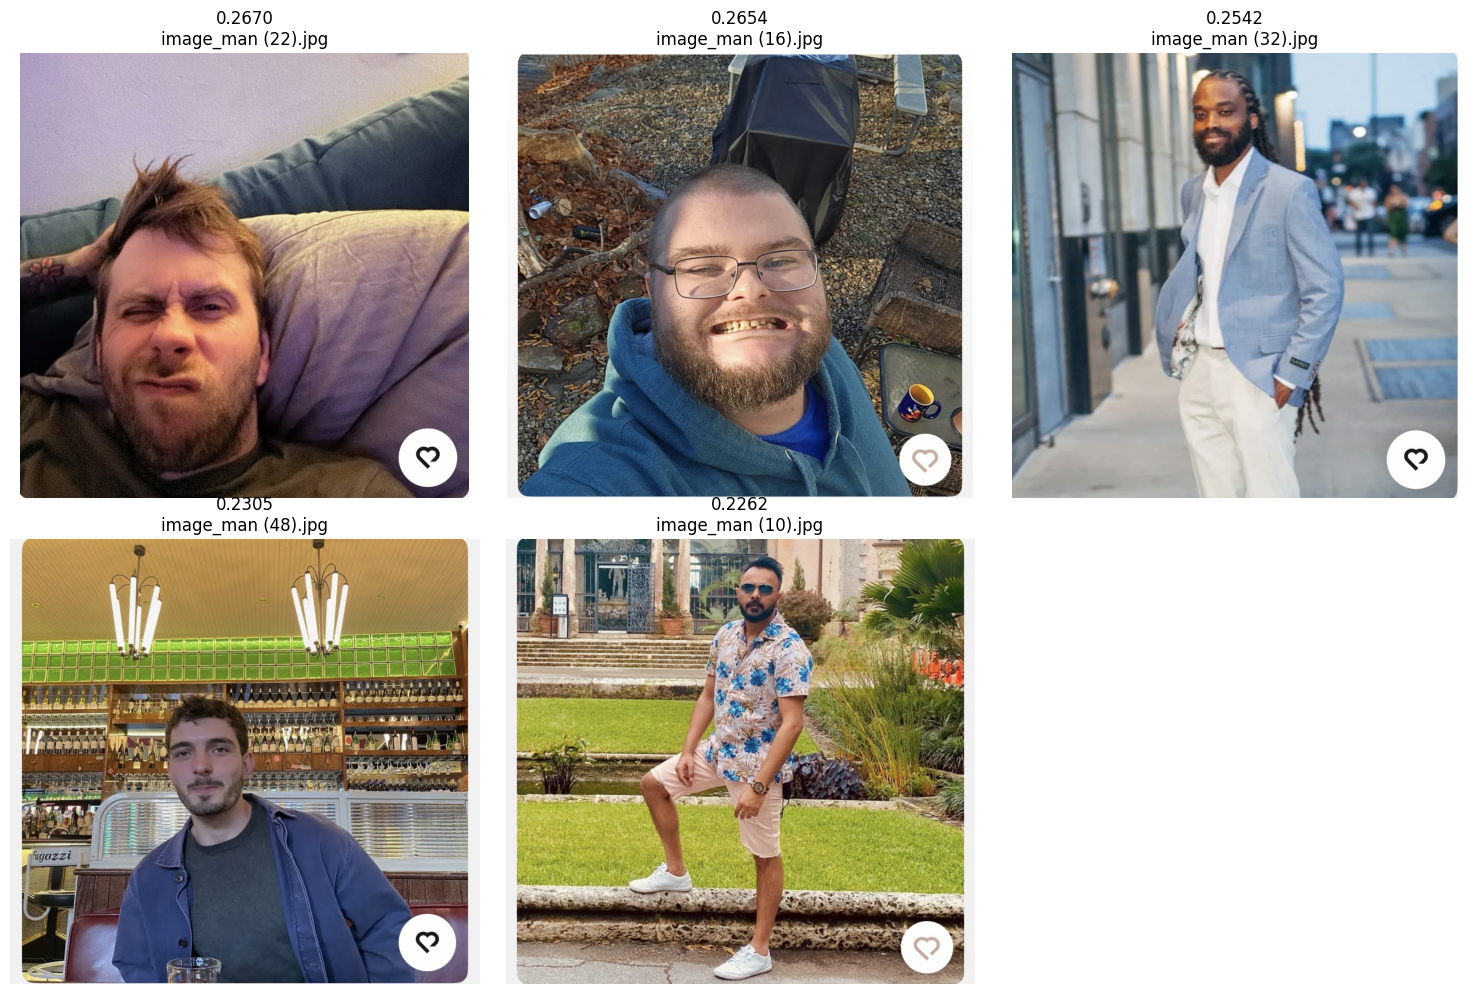

In [15]:
# ---- TEST IT ----
query = "guy with beard"
results = search_by_text(
    query=query,
    vectors=loaded_vectors,
    paths=loaded_paths,
    model=model,
    tokenizer=tokenizer,
    device=DEVICE,
    top_k=5
)
show_search_results(results)

In [16]:
def search_by_image(query_image, vectors, paths, model, preprocess, device="cpu", top_k=5):
    # Encode the query image into a CLIP vector
    tensor = preprocess(query_image).unsqueeze(0).to(device)
    with torch.no_grad():
        img_vec = model.encode_image(tensor)
        img_vec = img_vec / img_vec.norm(dim=-1, keepdim=True)
        img_vec = img_vec.cpu().numpy()

    # Cosine similarity with entire DB
    sims = (vectors @ img_vec.T).squeeze()

    # Top-K similar images
    top_idx = sims.argsort()[::-1][:top_k]
    results = [(paths[i], float(sims[i])) for i in top_idx]

    return results


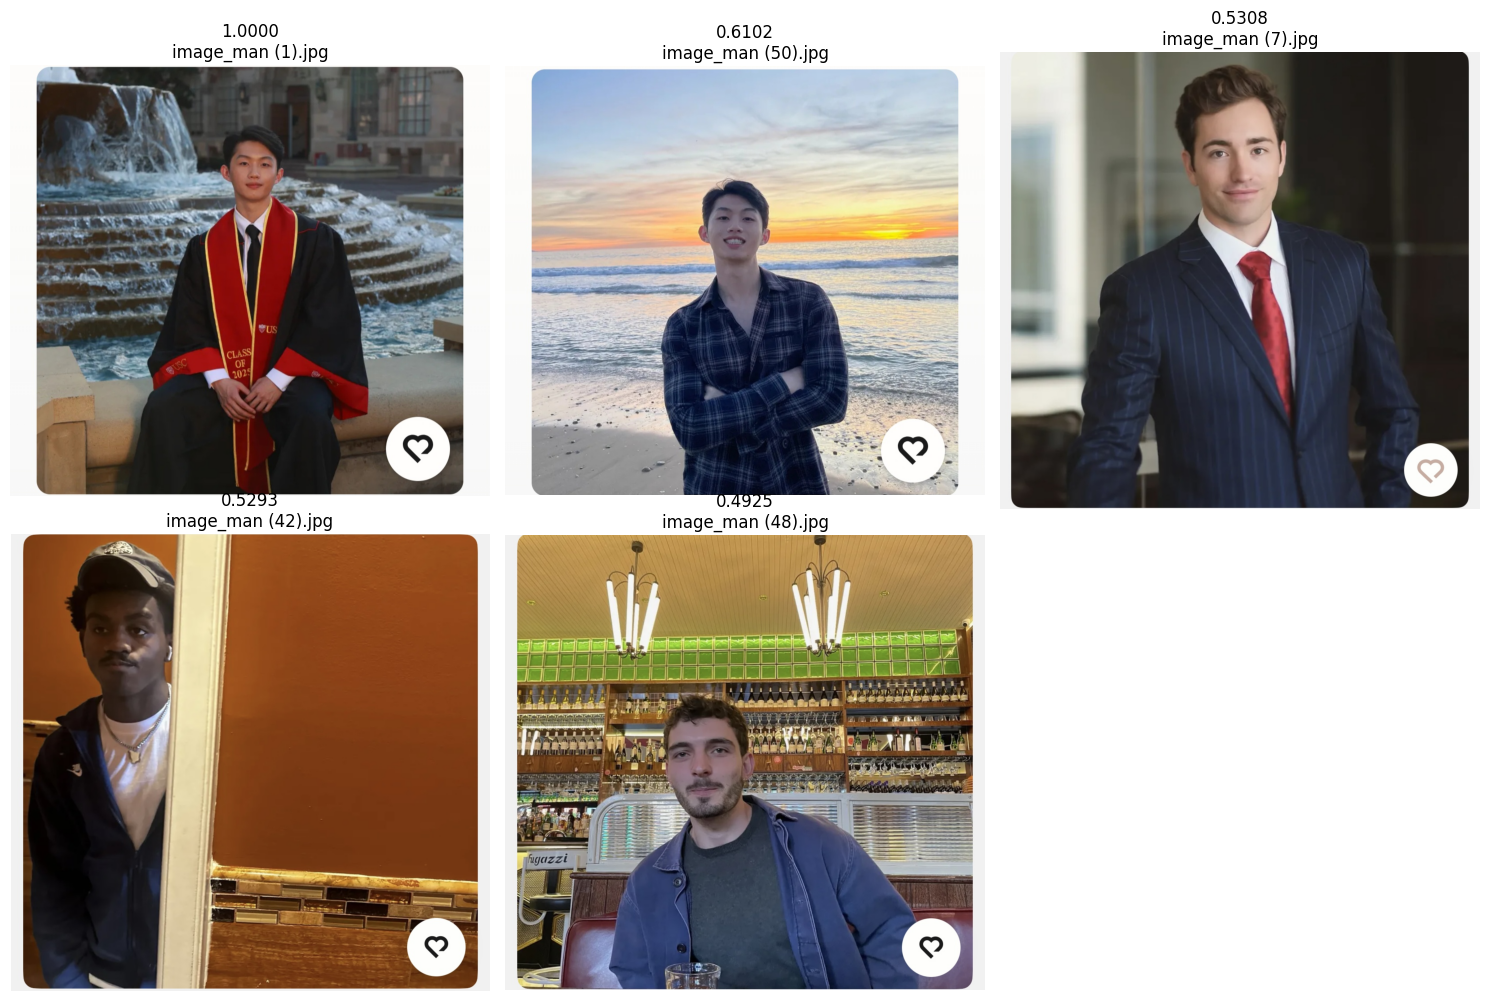

In [17]:
# ---- RUN IT ----
query_img = images[0]   # choose which image to search by
results_img = search_by_image(
    query_image=query_img,
    vectors=loaded_vectors,
    paths=loaded_paths,
    model=model,
    preprocess=preprocess,
    device=DEVICE,
    top_k=5
)

show_search_results(results_img)